In [1]:
import os
import tensorflow as tf
import keras
from keras.applications import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)
import keras.layers as layers

c:\Users\SoNotOkay\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Notebook run using keras: 2.14.0


## Constants

In [2]:
index = 2

### Model

In [3]:
model = Xception(weights='imagenet')
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

### Preprocess 

In [4]:
#Preprocess function
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

### Show images

In [5]:
folder_path = 'images'

# List all files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

# Load and preprocess all images in the folder
images = transform_img_fn(image_files)

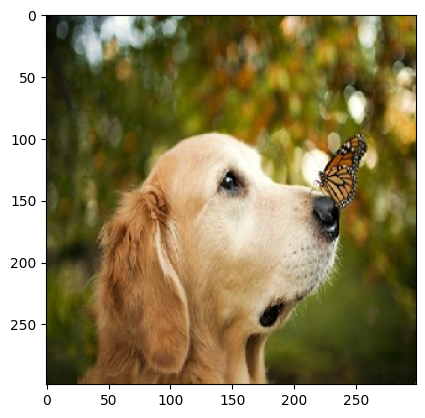

In [6]:
# Change the index value for different images, /2 + 0.5 is to show the image in the correct color
plt.imshow(images[index] / 2 + 0.5)

In [7]:
# Augmentation function
def apply_augmentation(images):
    augmentation = keras.Sequential([
        layers.RandomBrightness(0.5, value_range=(0, 1), seed=42),
        layers.RandomContrast(0.5, seed=42),
        layers.RandomFlip("horizontal_and_vertical", seed=42),
        layers.RandomRotation(0.5, seed=42),
    ])
    aug_images = augmentation(images)
    return aug_images

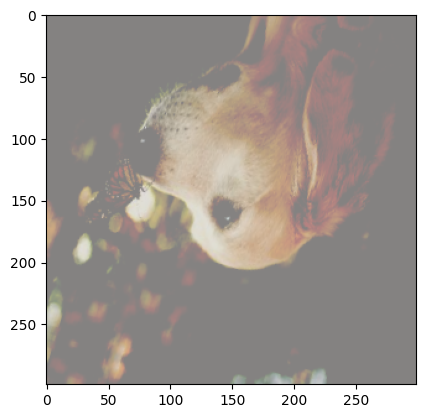

In [8]:
aug_images = apply_augmentation(images)

# Change the index value for different images, /2 + 0.5 is to show the image in the correct color
plt.imshow(aug_images[index] / 2 + 0.5)

### List Decoded Predictions

In [9]:
# Original image
preds = model.predict(images)

# Change the index value for different images
for x in decode_predictions(preds)[index]:
    print(x)

1/1 [==============================] - 3s 3s/step
('n02099601', 'golden_retriever', 0.73576736)
('n02099712', 'Labrador_retriever', 0.033836663)
('n02104029', 'kuvasz', 0.018768134)
('n02111500', 'Great_Pyrenees', 0.0067575397)
('n04409515', 'tennis_ball', 0.0038065573)


In [10]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
def to_numpy(tensor):
    return tensor.numpy() if hasattr(tensor, 'numpy') else tensor

aug_images = to_numpy(aug_images)

In [11]:
# Augmented image
preds = model.predict(aug_images)

# Change the index value for different images
for x in decode_predictions(preds)[index]:
    print(x)

1/1 [==============================] - 2s 2s/step
('n02099601', 'golden_retriever', 0.49686596)
('n02088364', 'beagle', 0.1275971)
('n02102177', 'Welsh_springer_spaniel', 0.06306017)
('n02102318', 'cocker_spaniel', 0.05650233)
('n02089867', 'Walker_hound', 0.04497639)


## Lime Explainer

In [22]:
explainer = lime_image.LimeImageExplainer()

# Change the index value for different images, and its going to take a while
explanation = explainer.explain_instance(images[index].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=50)
aug_explanation = explainer.explain_instance(aug_images[index].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=50)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 20%|██        | 10/50 [00:01<00:07,  5.42it/s]

1/1 [==============================] - 2s 2s/step


 40%|████      | 20/50 [00:03<00:05,  5.08it/s]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 30/50 [00:05<00:04,  4.93it/s]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 40/50 [00:08<00:02,  4.92it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 20%|██        | 10/50 [00:01<00:06,  6.02it/s]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 29/50 [00:03<00:02,  9.21it/s]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 34/50 [00:05<00:03,  5.12it/s]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 48/50 [00:08<00:00,  5.98it/s]

1/1 [==============================] - 2s 2s/step


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


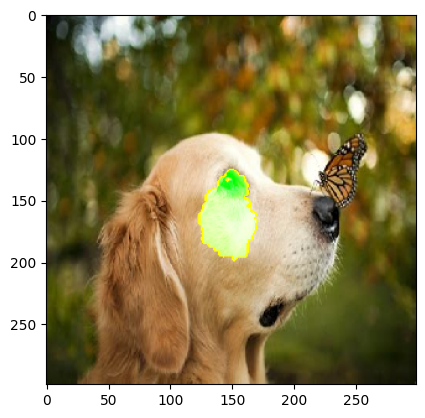

In [23]:
# Change the index value to explain different labels
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False, min_weight=0.01)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

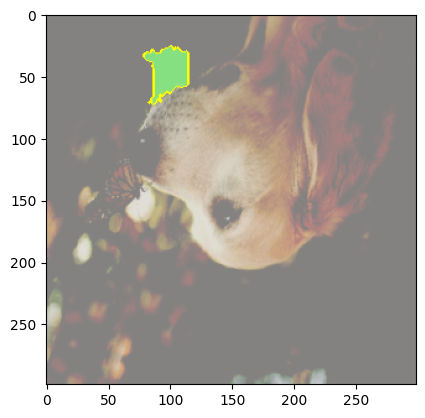

In [24]:
temp, mask = aug_explanation.get_image_and_mask(aug_explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Heat Map

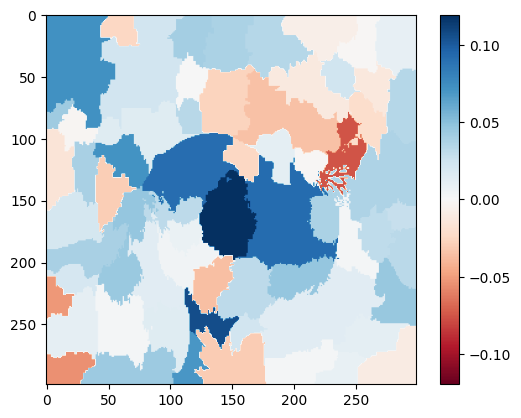

In [25]:
# Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

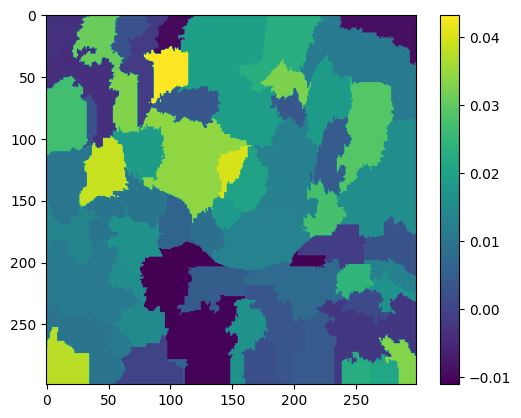

In [26]:
# Select the same class explained on the figures above.
ind =  aug_explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(aug_explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(aug_explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap)#, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()